# GSD: part of developing plotting for nucloetide difference imbalance

Boiled down development of making a line plot like GC imbalance in Figure 8, panel B of [Morrill et al 2016(PMID: 27026700)](https://www.ncbi.nlm.nih.gov/pubmed/27026700).

------




##  Preparation

Get the script that allows fetching of sequences of regions along a chromosome by coordinates.

In [2]:
# Get the script
!curl -OL https://raw.githubusercontent.com/fomightez/yeastmine/master/get_chromosomal_coordinates_as_FASTA.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16020  100 16020    0     0  60452      0 --:--:-- --:--:-- --:--:-- 60452


Get a sequence to work with.

In [3]:
%run get_chromosomal_coordinates_as_FASTA.py IV 200000-220000

Sequence on Watson strand specified...retrieving sequence from chromosome IV...making FASTA formatted entry with retrieved sequence...

File of genomic sequence saved as 'S288C_chrIV_200000-220000_genomic.fsa'.
Finished.


Get sequence into memory.

In [4]:
!pip install pyfaidx

  Stored in directory: /home/jovyan/.cache/pip/wheels/54/a2/b4/e242e58d23b2808e191b214067880faa46cd2341f363886e0b
Successfully built pyfaidx


In [5]:
from pyfaidx import Fasta
#import pandas as pd
#import collections
seq_entries = Fasta("S288C_chrIV_200000-220000_genomic.fsa")
seq = seq_entries[0]
str(seq)[:100]

'CTGCTAAAGTTCCATCTAACGCCACGTTTAAGAACAAGGAAAAACCTCAAGAGGTTCGCAAAGCCAACATCATCGCTGCACGTTCTGTTGCAGATGCCAT'

## Testing with current implementation of code for counting nucleotide difference imbalance

In [6]:
def gen_chunk_string_with_different_step(a_list, chunk_size, step_amount):
    """Yield successive n-sized chunks from list, stepping /stride by step_amount."""
    for i in range(0, len(a_list), step_amount):
        yield a_list[i:i+chunk_size]
chunk_size = 150 #for 150 bp window
overlap_specified = 50 #50 bp overlap of windows
step_size = chunk_size - overlap_specified #100 for chunk_size of 150 and overlap of 50
chunks = (list(gen_chunk_string_with_different_step(seq,chunk_size,step_size)))
#discard any chunks at end less than the size of the set window
chunks = [x for x in chunks if len(x)== chunk_size]
len(chunks)

199

In [ ]:
#determining midpoints for each chunk (relative length of provided sequence) and assiging to a dictionary
def midpoint(items):
    '''
    takes a iterable of items and returns the midpoint (integer) of the first 
    and second values
    '''
    return int((int(items[0])+int(items[1]))/2)


import sys
chunks_midpoints = {} #key will be index of chunk in chunks
for indx,chunk in enumerate(chunks):
    if indx == 0 and len(chunk)== chunk_size:
        chunks_midpoints[indx] = chunk_size/2
    elif len(chunk)== chunk_size:
        start_curr_chunk = step_size * indx
        end_curr_chunk = step_size * indx + chunk_size
        chunks_midpoints[indx] = midpoint((start_curr_chunk,end_curr_chunk)) 
    else:
        sys.stderr.write("\n\nChunks not expected size?\n")
        sys.exit(1)
#chunks_midpoints  

In [9]:
# correct chunks_midpoints to take into account that first postion in provided sequence might not be
# first position of that sequence along chromosome
chr_start_pos = 200000
chunks_midpoints = {k:v+chr_start_pos for k,v in chunks_midpoints .items()}
#chunks_midpoints

In [10]:
#Calculate G vs. C and A vs. T that I think might give results like Figure 8 of Morrill et al 2016 (PMID: 27026700)
def calc_nt_diff(di_base,seq):
    '''
    Takes a string made of two bases along with a sequence 
    as a string. Calculates the nucleotide different 
    imbalance value for the base combination and returns that.
    It is insensitive to case.
    Nucleotide different imbalance value is meant to match
    Figure 8 of Morrill et al 2016 (PMID: 27026700). I found
    the description of the calculation and what was being 
    plotted rather vague, and so it took some testing of my
    speculations to work this out.
    
    '''
    assert len(di_base) == 2, ("The `calc_nt_diff` function takes "
    "a string of two bases, such as 'GC' or 'AT'.")
    first_base = di_base[0].lower()
    secnd_base = di_base[1].lower()
    return seq.lower().count(secnd_base) - seq.lower().count(first_base)

chunks_diffs = {} #key will be index of chunk in chunks. value will be tuple with each diff as an item
for indx,seq in enumerate(chunks):
    GC_diff = calc_nt_diff("GC",str(seq)) # casting 'Sequence' object to string with `str(seq)`
    AT_diff = calc_nt_diff("AT",str(seq)) # casting 'Sequence' object to string with `str(seq)`
    chunks_diffs[indx] = (GC_diff,AT_diff)

In [11]:
#chunks_diffs

## Plotting results 

(Looks like the way in next cell will work for my data since dictionaries now ordered.
But maybe in final form should just keep both as litst so compatible with 2.7??)

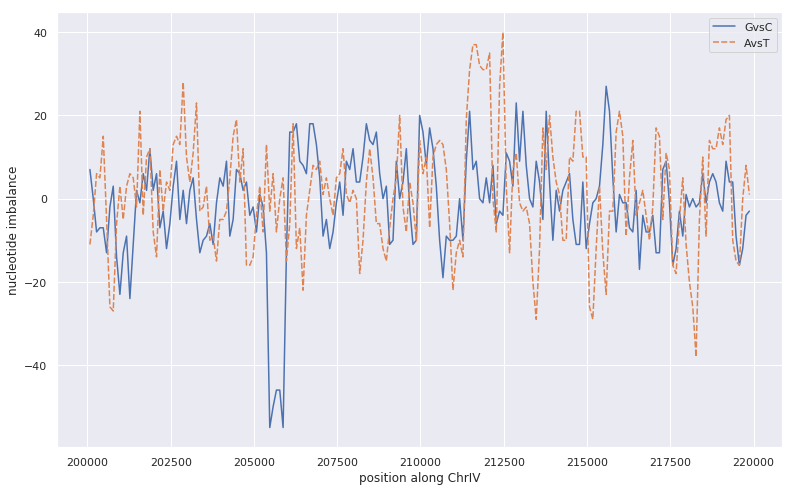

In [17]:
%matplotlib inline
# adapting code from https://seaborn.pydata.org/generated/seaborn.lineplot.html
plt.figure(figsize=(13,8))
indx = list(chunks_midpoints.values())
data = list(chunks_diffs.values())
wide_df = pd.DataFrame(data, indx, ["GvsC", "AvsT"])
ax = sns.lineplot(data=wide_df)
ax.set_ylabel("nucleotide imbalance");
ax.set_xlabel("position along ChrIV");

#### RESULT

Overall pattern identical and so process close to worked out. However, extremes not as extreme, especially on low end near CTD repeat region as [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4882425/figure/F8/). Look at y-axis, especially. Plus the last extreme 'AvsT' peak goes more negative on the right side than theirs.

I did wonder if they just had the phase of their 150 windows fall on a better location than mine that started at the 200000 of Chr IV, but I could never find a place where the imbalance would be more negative than -61 even if I made the step one base at a time.